In this tutorial, we learn how to quantify interactions between two time-series. We will cover,
<!-- * Cross-correlation function -->
* Mutual information
* Transfer entropy
* Predictive information decomposition


<!-- ### Key words
 -->
### References


(1) Kawano, A., O’Shaughnessy, L., Neiman, R., Deligkaris, K., Rodriguez, L.C., Masai, I., Stephens, G.J., 2025. Decomposing Predictive Information in Social Dynamics. https://doi.org/10.1101/2025.05.16.654393

(2) O’Shaughnessy, L., Izawa, T., Masai, I., Shaevitz, J.W., Stephens, G.J., 2024. Dynamics of Dominance in Interacting Zebrafish. PRX Life 2, 043006. https://doi.org/10.1103/PRXLife.2.043006




In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.linalg as lin
import numpy.ma as ma
import math
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 16})

## Data and Coordinate system

Throughout the tutorial, we use the 3D behavioral tracking data of zebrafish dominance contest. The details of the experiment and tracking can be found in [2]. 

To capture their movement, we use the pectoral point velocity of each individual, and project the velocity vector onto the joint coordinate (Fig. A). For example, the approach velocity $v_r$ captures important agonistic interactions such as attack and chasing behavior, where $v_r$ is mostly positive for the chaser and negative for the fish being chased (Fig. B).

<img src= "fig/coordinate.png" alt="processed image" align="middle" width="800"/>

Let's import the time-series of one of the recording and examine the trend of $v_r$ over the recording by computing its window average. 

In [2]:
# main_load_folder = '/bucket/StephensU/akira/data/tracking_results/'


# # the path for loading the fightbout info
# fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')

# with h5py.File(fightBouts_info_path, 'r') as hf:
#     fight_bout_info = hf['fight_bout_info'][:]
#     fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

fight_bout_info = np.load('./data/fight_bout_info.npy')
    
expid = 10
dataname = './data/v_4_'+str(expid)
vr = np.load(dataname+'.npy',allow_pickle=1)[:,:,0]
vs = np.load(dataname+'.npy',allow_pickle=1)[:,:,:]
fight_start = fight_bout_info[np.where(fight_bout_info.T[0]==expid)][0,1]
fight_end = fight_bout_info[np.where(fight_bout_info.T[0]==expid)][0,2]

dt = 1/100

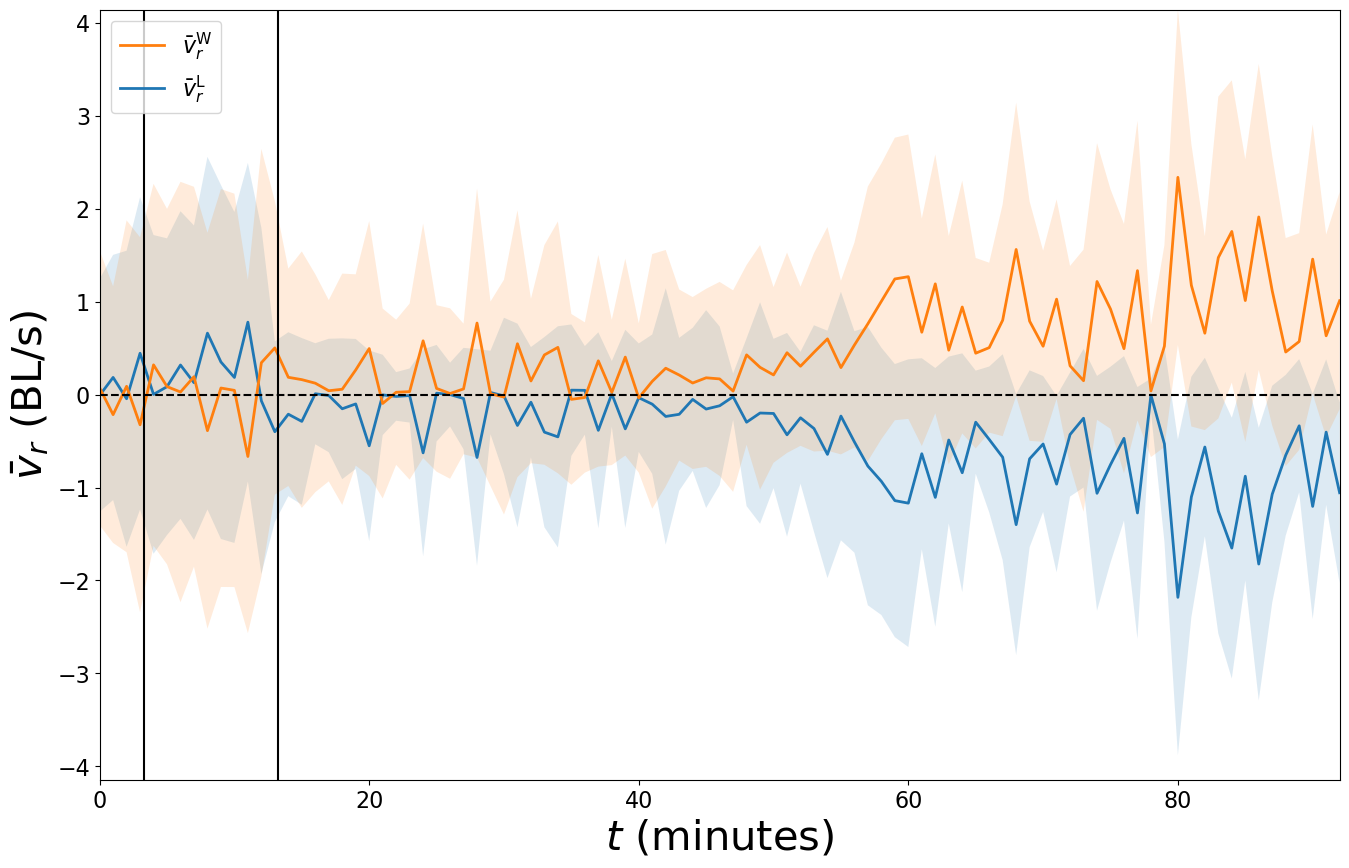

In [4]:
l = int(60/dt) # interval
w = int(60/dt) # window length


def moving_average(a,l,t=1):
    '''
    a : time series 
    l : window sise 
    t : moving step (step to move the window)
    '''
    b = np.empty(int(len(a)/t))
    b[:] = np.nan
    try:
        b[math.floor(l/2/t):] = np.array([np.nanmean(a[i*t:i*t+l]) for i in range(math.ceil((len(a)-l)/t))])
    except:
        try:
            b[math.floor(l/2/t):-math.floor(l/2/t)] = np.array([np.nanmean(a[i*t:i*t+l]) for i in range(math.floor((len(a)-l)/t))])
        except:
            b[math.floor(l/2/t):-math.floor(l/2/t)] = np.array([np.nanmean(a[i*t:i*t+l]) for i in range(math.ceil((len(a)-l)/t))])
    return b
def moving_sd(a,l,t=1):
    '''
    a : time series 
    l : window sise 
    t : moving step (step to move the window)
    '''
    b = np.empty(int(len(a)/t))
    b[:] = np.nan
    try:
        b[math.floor(l/2/t):] = np.array([np.sqrt(np.nanmean(a[i*t:i*t+l]**2) - np.nanmean(a[i*t:i*t+l])**2) for i in range(math.ceil((len(a)-l)/t))])
    except:
        try:
            b[math.floor(l/2/t):-math.floor(l/2/t)] = np.array([np.sqrt(np.nanmean(a[i*t:i*t+l]**2) - np.nanmean(a[i*t:i*t+l])**2) for i in range(math.floor((len(a)-l)/t))])
        except:
            b[math.floor(l/2/t):-math.floor(l/2/t)] = np.array([np.sqrt(np.nanmean(a[i*t:i*t+l]**2) - np.nanmean(a[i*t:i*t+l])**2) for i in range(math.ceil((len(a)-l)/t))])
    return b

mean_projvel_1 = moving_average(vr[0],w,l)
mean_projvel_2 = moving_average(vr[1],w,l)
sd_projvel_1 = moving_sd(vr[0],w,l)
sd_projvel_2 = moving_sd(vr[1],w,l)

plt.figure(figsize=[16,10])
time = [i/6000*l for i in range(len(mean_projvel_1))]
plt.plot(time,mean_projvel_2,label='${\\bar v_r^\mathrm{L}}$',lw=2.)
plt.plot(time,mean_projvel_1,label='${\\bar v_r^\mathrm{W}}$',lw=2.)
plt.fill_between(time,mean_projvel_2+sd_projvel_2/2.,mean_projvel_2-sd_projvel_2/2.,alpha=.15)
plt.fill_between(time,mean_projvel_1+sd_projvel_1/2.,mean_projvel_1-sd_projvel_1/2.,alpha=.15)
y0 = min(np.nanmin(mean_projvel_1-sd_projvel_1/2),np.nanmin(mean_projvel_2-sd_projvel_2/2.))
y1 = max(np.nanmax(mean_projvel_1+sd_projvel_1/2),np.nanmax(mean_projvel_2+sd_projvel_2/2.))
plt.ylim([-y1,y1])
plt.xlim([time[0],time[-1]])
plt.hlines(0,time[0],time[-1],colors='k',linestyles='--')
plt.vlines(fight_start/6000,-y1,y1,colors='k',linestyles='-')
plt.vlines(fight_end/6000,-y1,y1,colors='k',linestyles='-')
plt.xlabel('$t$ (minutes)',fontsize=30)
plt.ylabel('${\\bar v_{r}}$ (BL/s)',fontsize=30)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="upper left") 

plt.show()

The solid line shows the window-average and the shaded area shows window-standard deviation. The region between two vertical bars is the fight epoch. 

## Mutual Information
Next, we aim to quantify their interactions by computing mutual information in each time-window. Here, we approximate the underlying distribution within each window is Gaussian and adopt an analytic formula for mutual information for Gaussian variables. 

\begin{equation}
    I\left(X;Y\right)=\frac{1}{2}\log\frac{\left|\Sigma_{X}\right|\left|\Sigma_{Y}\right|}{\left| \Sigma_{X,Y} \right|}
\end{equation}

where $\left|\Sigma\right|$ is the determinant of the covariance matrix.

[Technical points] You may wonder how well the distribution is approximated by a Gaussian. This is often difficult to verify directly from data. In [1], we maximize the validity of approximation by finding the optimal time-window size that maximizes the (predictive) mutual information. For the covariance matrix estimation, we adopt the OAS estimator. For more details of the estimation of information measures under Gaussian approximation, please refer to Methods in [1].

We consider the interaction between approach velocities $v_r$ of winner fish (W) and of loser fish (L).

<!-- We consider the interaction between velocities $\{v_r,v_\theta,v_z\}$ of winner fish (W) and of loser fish (L). -->

In [5]:
def rho_oas(X,S):
#     n = X.shape[0]-np.sum(np.isnan(X.T[0]));p = X.shape[1]
    n = X.shape[0]*(1.-np.sum(np.isnan(X.T[0]))/X.shape[0])**2;p = X.shape[1]
    a = (1-2/p)*np.trace(S@S)+np.trace(S)**2
    b = (n+1-2/p)*(np.trace(S@S)-np.trace(S)**2/p)
    return a/b

def LW(c,cov):
    p = cov.shape[0]
    rho = np.min([rho_oas(c,cov),1.])
#     print(rho)
    F = (np.trace(cov)/p)*np.identity(p)
    return (1.-rho)*cov + rho*F

def mycov(c,th=10**-2):
    cov = ma.cov(ma.masked_invalid(c.T))
    if np.ndim(cov)==0:
        return cov
    else:
        val,rvec,lvec = lin.eig(ma.getdata(cov), left=True, right=True)
        val,rvec,lvec = val.real,rvec.real,lvec.real
    #     val[np.where(val<=th)]=np.min(val[np.where(val>th)])
    #     th = np.max(val)*th
        val[np.where(val<=th)]=th
        cov_c = rvec @ np.diag(val) @ lvec.T
        cov_c = LW(c,cov_c)
        return cov_c

# def entropy_gaussian(c):
#     n = c.shape[0]
#     a = n/2.*np.log2(2.*np.pi*np.e)
#     logdet = np.linalg.slogdet(c)
#     b = logdet[1]*np.log2(np.e)/2.
#     return a+b


def entropy_gaussian(covariance):
    if np.ndim(covariance)==0:
        # Univariate Gaussian entropy: (1/2) * log(2πeσ²)
        entropy = 0.5 * np.log2(2 * np.pi * np.e * covariance)
    else:
        # Multivariate Gaussian entropy: (n/2) * log(2πe) + (1/2) * log|Σ|
        n = covariance.shape[0]
        a = n / 2. * np.log2(2 * np.pi * np.e)
        sign, logdet = np.linalg.slogdet(covariance)
        if sign <= 0:
            raise ValueError("Covariance matrix must be positive definite.")
        b = logdet * np.log2(np.e) / 2.
        entropy = a + b
    return entropy


def MI_gaussian(x,y):
    '''
    compute I(x;y)
    '''
    if len(x.shape)==1 or len(y.shape)==1:
#         a = np.stack((x,y),axis=0).T
        a = np.vstack([x.T,y.T]).T
#         print(a.shape)
    else:
        a = np.concatenate((x,y),axis=1)
#         print(a.shape)
    
    cov_xy = mycov(a)
    cov_x = mycov(x)
    cov_y = mycov(y)

    hy = entropy_gaussian(cov_y)
    hx = entropy_gaussian(cov_x)
    hxy = entropy_gaussian(cov_xy)
    
    return (hx+hy-hxy)#/np.max([hx,hy])

In [6]:
l = int(10/dt) # interval
w = int(30/dt) # window length
MIs = []

for i in range(int(vs.shape[1]/l)):
    MIs.append(MI_gaussian(vr[0,i*l:i*l+w],vr[1,i*l:i*l+w]))

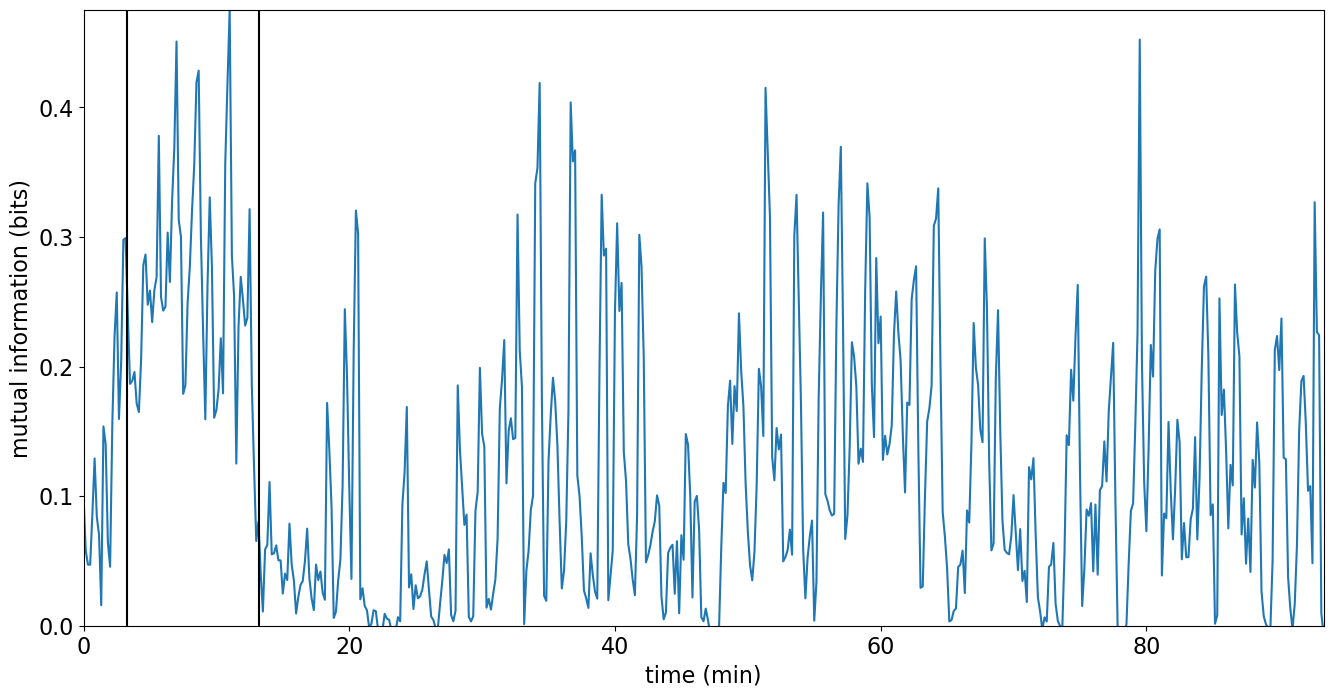

In [7]:
plt.figure(figsize=[16,8])
time = [i/6000*l for i in range(len(MIs))]
plt.plot(time,MIs)
plt.ylim([0,np.max(MIs)])
plt.xlim([time[0],time[-1]])
plt.axvline(fight_start/6000,c='k')
plt.axvline(fight_end/6000,c='k')
plt.ylabel('mutual information (bits)')
plt.xlabel('time (min)')
plt.show()

We can see that mutual information is high during the fight, implying two fish movements are highly coupled. 

## Transfer Entropy
Next, we compute transfer entropy in each time-window under the Gaussian approximation. Transfer entropy measures how much of the predictive information is gained by knowing the external variable. Thus, we should consider the dynamics, $X^\mathrm{past}$ and $X^\mathrm{future}$ etc. Transfer entropy from $Y$ to $X$ is defined by,
\begin{equation}
T_{Y\rightarrow X}=I\left(\{X^\mathrm{past},Y^\mathrm{past}\};X^\mathrm{future}\right) - I\left(X^\mathrm{past};X^\mathrm{future}\right)
\end{equation}

We use $X^\mathrm{past}=v_r^t$ and $X^\mathrm{future}=v_r^{t+\tau}$ with $\tau=50$ frames (0.5 s).
<!-- We use $X^\mathrm{past}=\{v_r^t,v_\theta^t,v_z^t\}$ and $X^\mathrm{future}=\{v_r^{t+\tau},v_\theta^{t+\tau},v_z^{t+\tau}\}$. -->

In [8]:
def TE(x,y,tau=50):
    '''
    compute TE_x->y = I(y_future;x_past,y_past)-I(y_future;y_past)
    ''' 
    y_future = y[tau:]
    y_past = y[:-tau]
    x_past = x[:-tau]
    
    if len(x_past.shape)==1:
        xy = np.stack((x_past, y_past), axis=0).T#np.concatenate((x_past,y_past),axis=1)
#         print(y_future.shape,xy.shape)
    else:
        xy = np.concatenate((x_past,y_past),axis=1)
#         print(x_past.shape,xy.shape)
    
    
    return MI_gaussian(y_future,xy)-MI_gaussian(y_future,y_past)
    

In [9]:
l = int(10/dt) # interval
w = int(30/dt) # window length
TE_WtoL = []
TE_LtoW = []

for i in range(int(vs.shape[1]/l)):
    TE_WtoL.append(TE(vr[0,i*l:i*l+w],vr[1,i*l:i*l+w]))
    TE_LtoW.append(TE(vr[1,i*l:i*l+w],vr[0,i*l:i*l+w]))
#     TE_WtoL.append(TE(vs[0,i*l:i*l+w],vs[1,i*l:i*l+w]))
#     TE_LtoW.append(TE(vs[1,i*l:i*l+w],vs[0,i*l:i*l+w]))

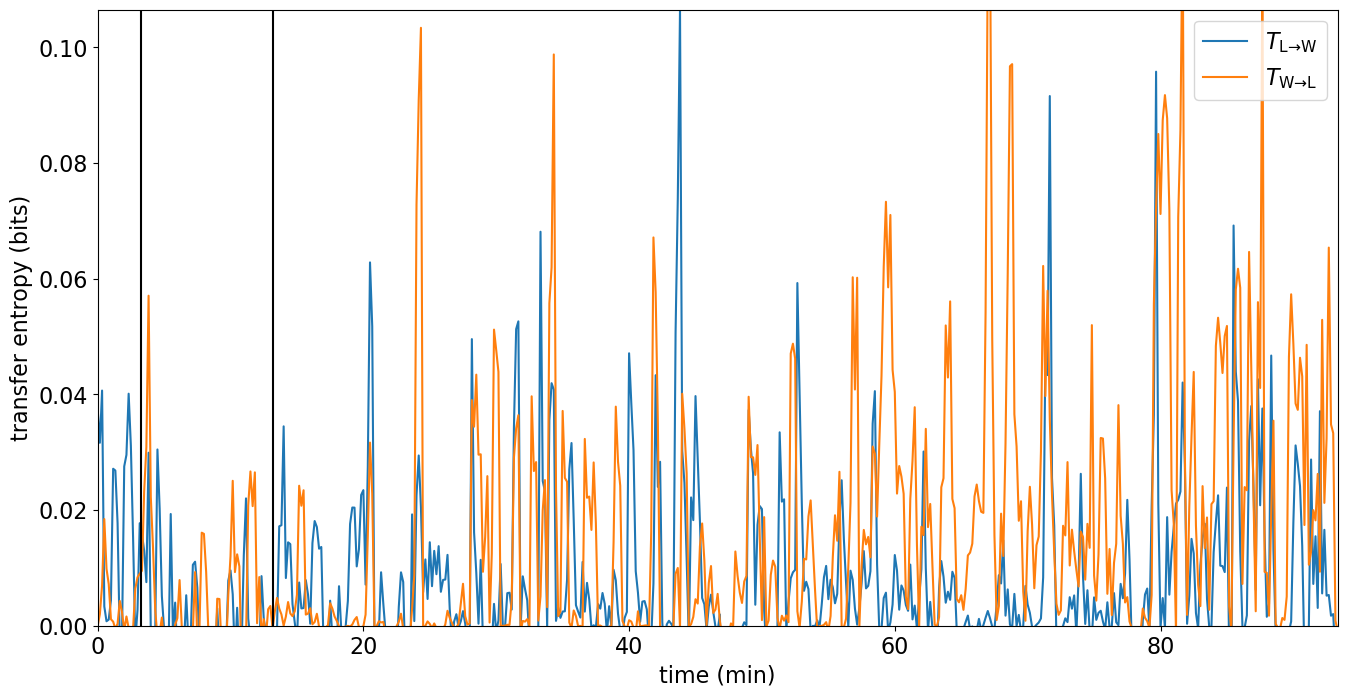

In [10]:
plt.figure(figsize=[16,8])
time = [i/6000*l for i in range(len(TE_LtoW))]
plt.plot(time,TE_LtoW,label='$T_\mathrm{L\\to W}$')
plt.plot(time,TE_WtoL,label='$T_\mathrm{W\\to L}$')
plt.ylim([0,np.max(TE_LtoW)])
plt.xlim([time[0],time[-1]])
plt.axvline(fight_start/6000,c='k')
plt.axvline(fight_end/6000,c='k')
plt.ylabel('transfer entropy (bits)')
plt.xlabel('time (min)')
# plt.ylim([0,0.2])
plt.legend()
plt.show()

<!-- Transfer entropy is symmetric between the winner (W) and loser (L) in the fight epoch. Interestingly, the symmetry is broken after the fight and transfer entropy is larger from the loser than from the winner. This might be difficult to interpret as we use all velocity components together. You could exploler different diffinitions for variables such as using $X^\mathrm{past}$ and $X^\mathrm{future}$ by, for example, changing $\tau$.  -->


Interestingly, towards the end of recording, transfer entropy from winner to loser becomes larger than from loser to winner, which may reflect their dominant interactions. Note that transfer entropy is sensitive to the time lag $\tau$ (you can explore this by your self!). We will consider more systematic choice of variables next for information decomposition. 

## Predictive Information Decomposition
Next, we compute the partial information decomposition (PID) of predictive information. We aim to describe how the joint past state of the two individuals $s^\mathrm{past}_i$ and $s^\mathrm{past}_j$ predicts the future state of either individual $s^\mathrm{future}_i$. This predictive relationship is naturally quantified using the joint mutual information,
\begin{equation}\label{eq:total_info_flow}
I\left(\{s_i^\mathrm{past},s_j^\mathrm{past}\};s_i^\mathrm{future}\right)=\left\langle\log{\frac{P(s_i^{\mathrm{future}}|s_i^\mathrm{past},s_j^\mathrm{past})}{P(s_i^{\mathrm{future}})}}\right\rangle
\end{equation}

PID decomposes this predictive information into four "information atoms", 

\begin{equation}
I\left(\{s_i^\mathrm{past},s_j^\mathrm{past}\};s_i^\mathrm{future}\right)=R_{i,j\to i}+U_{i\to i}+U_{j\to i}+S_{i,j\to i}
\end{equation}


where $R_{i,j\to i}$ denotes the redundant information about $s_i^\mathrm{future}$ shared by $s^\mathrm{past}_i$ and $s^\mathrm{past}_j$, $U_{i\to i}$ and $U_{j\to i}$ are unique information from $s^\mathrm{past}_i$ and $s^\mathrm{past}_j$ respectively about $s_i^\mathrm{future}$, and $S_{i,j\to i}$ represents the synergistic information about $s_i^\mathrm{future}$ available only in the joint state, $\{s_i^\mathrm{past},s_j^\mathrm{past}\}$.

In the context of social behavior, this decomposition provides intuitive "modes of social interaction". The redundant information $R_{i,j\to i}$ captures mirroring or synchronization between organisms. The self-unique information $U_{i\to i}$ provides a measure of independence. In contrast, the other-unique information $U_{j\to i}$ characterizes directional influence. The synergistic information $S_{i,j\to i}$ is the predictive information modified by the opponent, capturing joint actions or coordination. An example of such coordination is the division of labor, as seen in leader–follower roles: leaders determine the future group state, while followers adapt to the leader’s actions, where the followers’ predictive information is modified by the behavior of the leaders.

<img src= "fig/info_flow_mode.png" alt="processed image" align="middle" width="600"/>

We estimate PID here using an analytical solution for Gaussian variables called "minimal mutual information": 

\begin{equation}
R_{X_1,X_2\to Y} = \min_{i\in \{1,2\}} I(X_i;Y)
\end{equation}

The complete PID formula can be found in Methods of [1].

<!-- \begin{align*}
    R_{X_1,X_2\to Y} &= \min_{i\in \{1,2\}} I(X_i;Y) \\
    &=\frac{1}{2}\min \left(\log\frac{|\Sigma_Y|}{|\Sigma_{Y|X_1}|}, \log\frac{|\Sigma_Y|}{|\Sigma_{Y|X_2}|}\right) \\
    U_{X_1\to Y}&=\frac{1}{2}\max \left(\log\frac{|\Sigma_{Y|X_2}|}{|\Sigma_{Y|X_1}|},0\right) \\
    U_{X_2\to Y}&=\frac{1}{2}\max \left(\log\frac{|\Sigma_{Y|X_1}|}{|\Sigma_{Y|X_2}|},0\right) \\
    S_{X_1,X_2\to Y}&=\frac{1}{2}\min \left(\log\frac{|\Sigma_{Y|X_1}|}{|\Sigma_{Y|X_1,X_2}|},\log\frac{|\Sigma_{Y|X_2}|}{|\Sigma_{Y|X_1,X_2}|}\right) 
\end{align*} -->


We define a one-step future and a $\tau$-step past for each organism,

\begin{align*}
s_i^{\mathrm{past}}(t)&=[v_i(t-\tau),v_i(t-\tau+\mathrm{d}t),...,v_i(t)] \\
s_i^{\mathrm{future}}(t)&=v_i(t+\mathrm{d}t),
\end{align*}

and we illustrate our approach using the approach velocity $v_r^i$.  We choose $\tau=5\,\rm{s}$ to account for the significant cross-correlations.

<img src= "fig/for_tutorial.png" alt="processed image" align="middle" width="600"/>

In general, we can use multiple future steps $s^\mathrm{future}(t)=[v(t+\mathrm{d}t),v(t+2\mathrm{d}t),...,v(t+\tau)]$. However, the analytical PID solution, minimal mutual information, is valid only for a scalar future variable and thus we focused on the one step future. More discussion on this point can be found in [1]. 

Here, we compute PID of predictive information in $v_r$ from each 30s time-window. As the computation takes time, we compute them every 5 min across the recording. 

In [11]:
def delay(a,K,dim=0,s=1):
    K = K+1
    b = [np.reshape(a[i:i+K:s],(a[i:i+K:s].shape[1]*a[i:i+K:s].shape[0])) for i in range(a.shape[0]-(K-1))]
    return np.array(b)

def delay_1d(a,K,dim=0,s=1):
    K = K+1
    b = [a[i:i+K:s].T for i in range(a.shape[0]-(K-1))]
    return np.array(b)

def PID(x,y,tau,dt=1):
    '''
    compute I(x_future;x_past), I(x_future;y_past), and, I(x_future;x_past,y_past), and calculate PID
    x_future = [x_{t+dt}]
    x_past = [x_{t-tau},...,x_t]
    y_past = [y_{t-tau},...,y_t]
    '''
    if len(x.shape)==1:
        D = 1
    else:
        D = x.shape[1]
    if D == 1:
        a1 = delay_1d(np.array(x),tau)[:-dt].T[::-1].T
        a2 = delay_1d(np.array(y),tau)[:-dt].T[::-1].T
        b = delay_1d(np.array(x),tau)[dt:].T[::-1].T[:,0:D]
    else:
        a1 = delay(np.array(x),tau)[:-dt].T[::-1].T
        a2 = delay(np.array(y),tau)[:-dt].T[::-1].T
        b = delay(np.array(x),tau)[dt:].T[::-1].T[:,0:D]
    
    maxt = a1.shape[1]
    a = np.concatenate((a1,a2),axis=1)
    c = np.concatenate((b,a),axis=1)
    
    # computing total info flow I(z;x,y)
    cov_c = mycov(c)
    cov_a = cov_c[D:,D:]
    cov_b = cov_c[:D,:D]
    hb = entropy_gaussian(cov_b)
    ha = entropy_gaussian(cov_a)
    hab = entropy_gaussian(cov_c)
    Ixy = (ha+hb-hab)#/hb
    
    # computing individual mutual information I(z;x)
    cov_c = cov_c[:maxt+1,:maxt+1]
    cov_a = cov_c[D:,D:]
    cov_b = cov_c[:D,:D]
    hb2 = entropy_gaussian(cov_b)
    ha2 = entropy_gaussian(cov_a)
    hab2 = entropy_gaussian(cov_c)
    Ix = (ha2+hb2-hab2)#/hb2
    
    # computing individual mutual information I(z;y)
    a = np.concatenate((a2,a1),axis=1)
    c = np.concatenate((b,a),axis=1)
    cov_c = mycov(c)
    
    cov_c = cov_c[:maxt+1,:maxt+1]
    cov_a = cov_c[D:,D:]
    cov_b = cov_c[:D,:D]

    hb3 = entropy_gaussian(cov_b)
    ha3 = entropy_gaussian(cov_a)
    hab3 = entropy_gaussian(cov_c)
    Iy = (ha3+hb3-hab3)#/hb3
    
    # computing redundancy using the "minimum mutual information" measure
    
    R = np.min([Ix,Iy])
    Ux = Ix - R
    Uy = Iy - R
    S = Ixy - R - Ux - Uy
    
    return Ixy, R, Ux, Uy, S

    

In [12]:
l = int(300/dt) # interval
w = int(30/dt) # window length
PIDs_W, PIDs_L = [], []

tau = 500 # 5 seconds

for i in range(int(vs.shape[1]/l)):
    PIDs_W.append(PID(vr[0,i*l:i*l+w],vr[1,i*l:i*l+w],tau=tau))
    PIDs_L.append(PID(vr[1,i*l:i*l+w],vr[0,i*l:i*l+w],tau=tau))
    
PIDs_W = np.array(PIDs_W)
PIDs_L = np.array(PIDs_L)

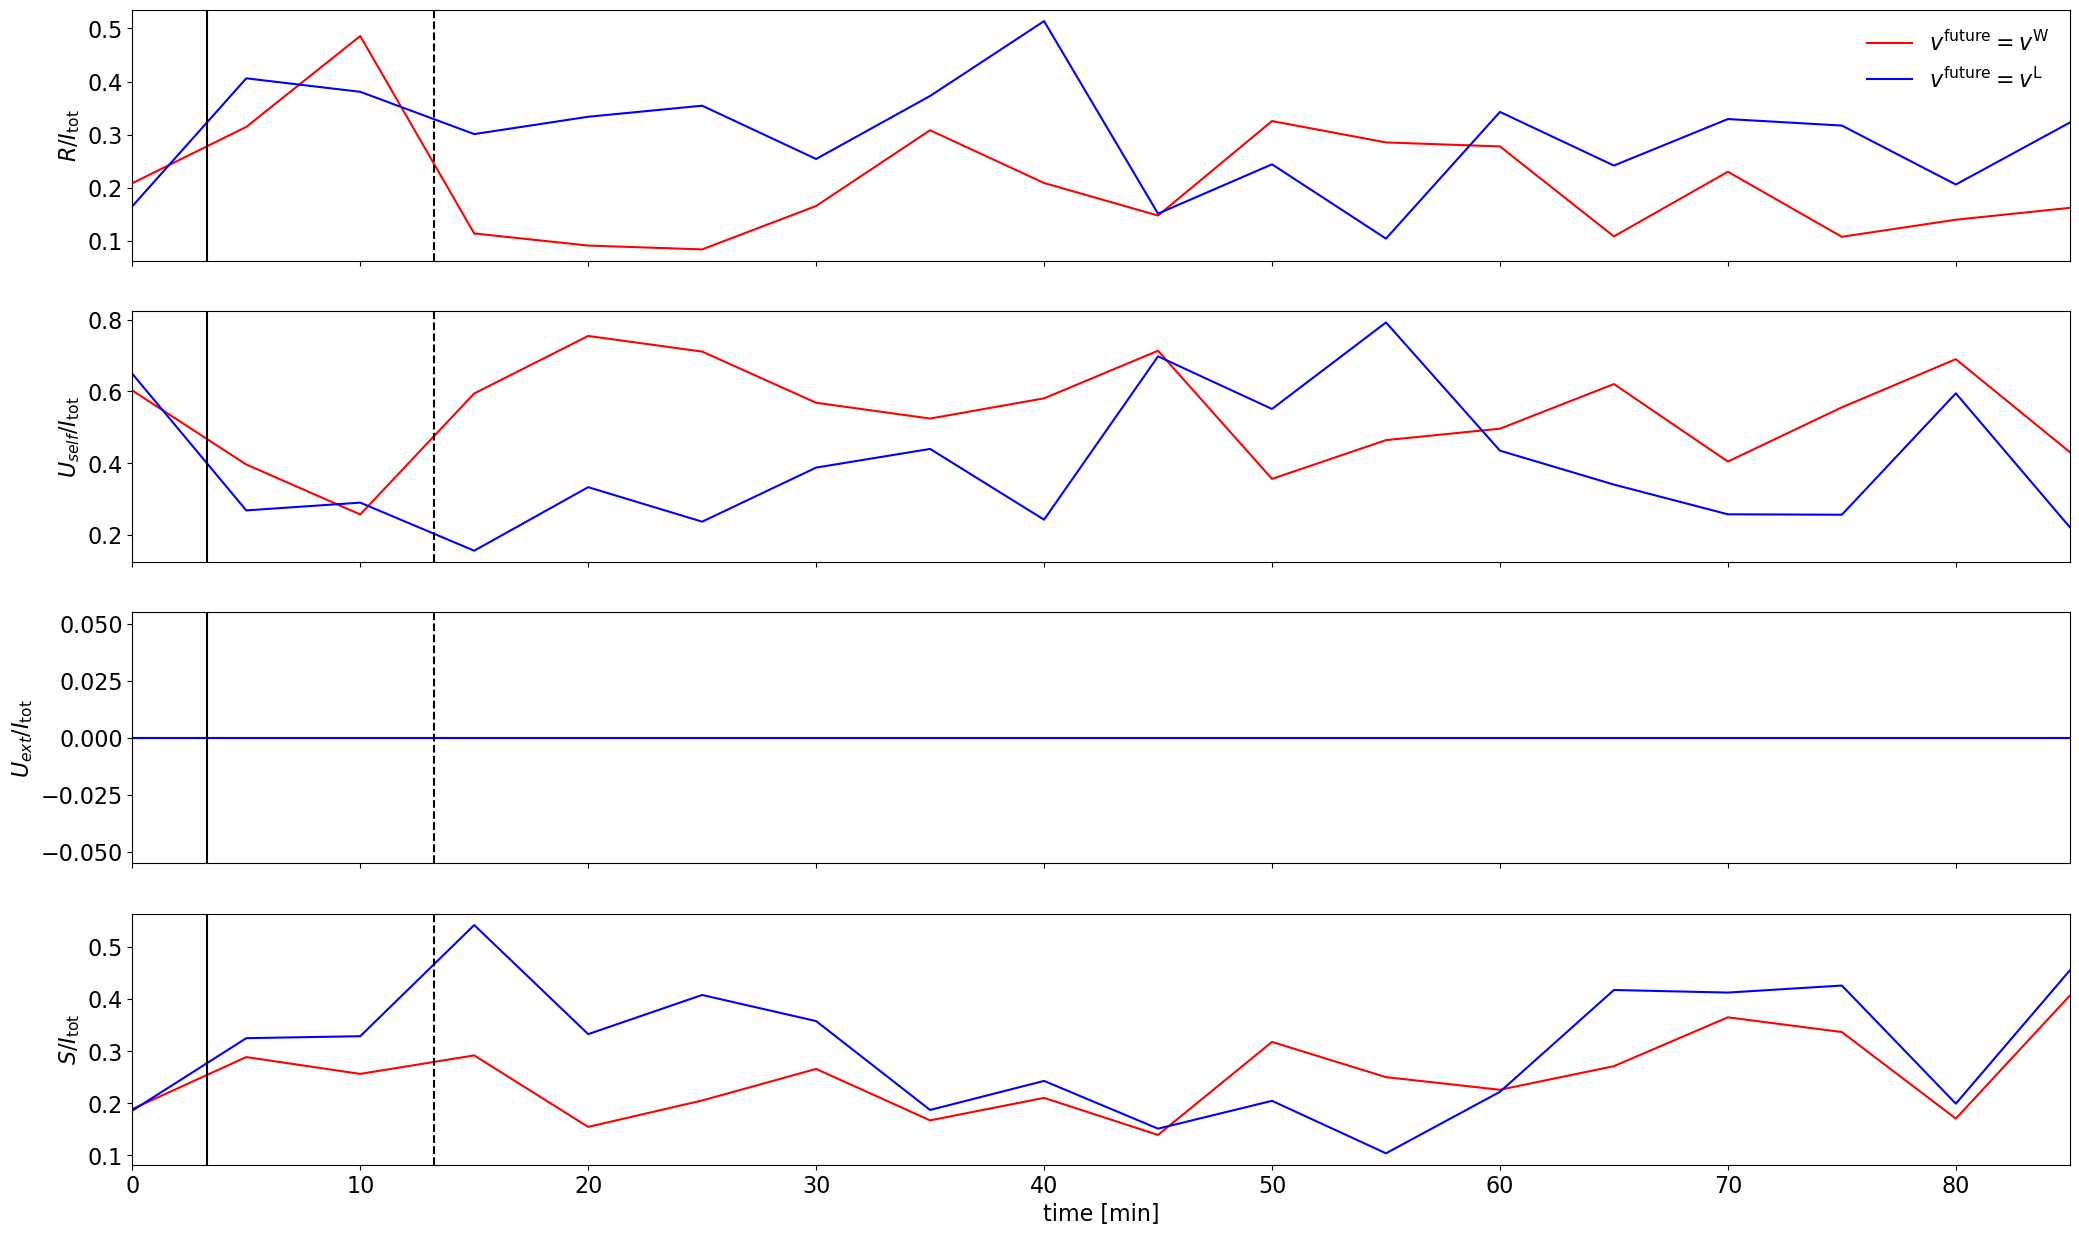

In [13]:
mi121 = PIDs_W[:,0]
r1 = PIDs_W[:,1]/mi121
u11 = PIDs_W[:,2]/mi121
u12 = PIDs_W[:,3]/mi121
s1 = PIDs_W[:,4]/mi121

mi212 = PIDs_L[:,0]
r2 = PIDs_L[:,1]/mi212
u22 = PIDs_L[:,2]/mi212
u21 = PIDs_L[:,3]/mi212
s2 = PIDs_L[:,4]/mi212

time = [i/6000*l for i in range(len(r1))]

fig, axs = plt.subplots(4, 1, figsize=(25, 15), sharex=True)

# Plot the data
axs[0].plot(time, r1, label='$v^\mathrm{future}=v^\mathrm{W}$',c='r')
axs[1].plot(time, u11, label='$R_{12\\to1}$',c='r')
axs[2].plot(time, u21, label='tan(x)',c='r')
axs[3].plot(time, s1, label='tan(x)',c='r')
# axs[4].plot(time, mi121, label='tan(x)',c='r')

axs[0].plot(time, r2, label='$v^\mathrm{future}=v^\mathrm{L}$',c='b')
axs[1].plot(time, u22, label='cos(x)',c='b')
axs[2].plot(time, u12, label='tan(x)',c='b')
axs[3].plot(time, s2, label='tan(x)',c='b')
# axs[4].plot(time, mi212, label='tan(x)',c='b')

# Remove x-tick labels for the first two plots
#     axs[0].tick_params(axis='x', labelbottom=False)
#     axs[1].tick_params(axis='x', labelbottom=False)
#     axs[2].tick_params(axis='x', labelbottom=False)

#     for ax in axs:
#         ax.legend(loc='upper right')

axs[0].legend(loc='upper right',framealpha=0.)
axs[0].set_ylabel('$R/I_\mathrm{tot}$')
axs[1].set_ylabel('$U_{self}/I_\mathrm{tot}$')
axs[2].set_ylabel('$U_{ext}/I_\mathrm{tot}$')
axs[3].set_ylabel('$S/I_\mathrm{tot}$')
# axs[4].set_ylabel('$I_\mathrm{tot}$')

# Set labels for the last plot
axs[3].set_xlabel('time [min]')
for fs in fight_bout_info[np.where(fight_bout_info.T[0]==expid)][:,1]:
    axs[0].axvline(fs/60*dt,c='k',ls='-')
    axs[1].axvline(fs/60*dt,c='k',ls='-')
    axs[2].axvline(fs/60*dt,c='k',ls='-')
    axs[3].axvline(fs/60*dt,c='k',ls='-')
#     axs[4].axvline(fs/60*dt,c='k',ls='-')
#     fe = fight_bout_info[np.where(fight_bout_info.T[0]==expid)][i,2]
for fe in fight_bout_info[np.where(fight_bout_info.T[0]==expid)][:,2]:
    axs[0].axvline(fe/60*dt,c='k',ls='--')
    axs[1].axvline(fe/60*dt,c='k',ls='--')
    axs[2].axvline(fe/60*dt,c='k',ls='--')
    axs[3].axvline(fe/60*dt,c='k',ls='--')
#     axs[4].axvline(fe/60*dt,c='k',ls='--')
axs[0].set_xlim([time[0],time[-1]])

plt.show()

As the total information $I\left(\{s_i^\mathrm{past},s_j^\mathrm{past}\};s_i^\mathrm{future}\right)$ also changes over time, we normalized each information atom by the total information, showing the fraction of decomposed flows.

We can observe that, during the fight, the redundunt information increases for both fish while the self-unique information decreases, implying more synchronized movements. Self-unique information rises again after the fight and includes a notable between-organism asymmetry: the self-unique information of the winner fish is higher. Thus one aspect of the emergent hierarchy is that the movements of the dominant fish are more independent. Redundant predictive information is higher for losers, reflecting their tendency for more mirroring. Synergy is also higher for losers. This indicates that, in post-fight, losers respond more to opponent movements compared to winners. Finally, opponent-unique information is zero, indicating that components of future movement uniquely determined by the opponent are negligible. 

You can find the average of those information flows across multiple experiments in [1].